# Conditional Computation
Called "neglection" in this implementation

In [2]:
import time
import os
import json
import random
import numpy as np
import librosa
import hashlib
import sounddevice as sd
import pickle as pkl
import dill
import datetime
import matplotlib.pyplot as plt
from torchsummary import summary

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader

from src.resnet import ResNet
from src.dataset import GoogleSpeechCommandsDataset
from src.train import test

/usr/lib/python3/dist-packages/paramiko/transport.py:220: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [11]:
# Parameters
measurements = [0., 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.]

use_snn = False
use_cpu = False
path = 'models/'
model_name = 'neglect_resnet_ep59_acc93_sprs0.pt' if use_snn else 'neglect_resnet_ep59_acc93_sprs0.pt'
base_model_name = 'resnnet_ep47_acc72_sprs68.pt' if use_snn else 'resnet_ep55_acc99_sprs0.pt'
data_test_dir = '/home/marcel/Source/Python/DLOptimization/data/speech_commands_test_set_v0.02'
data_cache_dir = '/home/marcel/Source/Python/DLOptimization/cache/data/'
load_data_from_dir = './runs/neglectbench/neglectbench.pkl'

In [9]:
# Load model
torch.set_flush_denormal(True)
device = torch.device("cuda" if not use_cpu and torch.cuda.is_available() else "cpu")
model_path = str(os.path.join(path, model_name))
model = ResNet.from_state_dict(torch.load(model_path), neglect=0.5)
model.neglect = True
base_model_path = str(os.path.join(path, base_model_name))
base_model = ResNet.from_state_dict(torch.load(base_model_path), spiking=True)
model.to(device)
base_model.to(device)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Load data
test_data = GoogleSpeechCommandsDataset(data_test_dir, data_cache_dir, encoder='mel', augment=0, train=False)
test_data.precache()
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

### Testing 
Baseline vs. Neglection Model

In [ ]:
(base_accuracy, base_sparsity, base_significance, 
 base_gpu_time, base_cpu_time_mean, base_cpu_time_std, base_num_params) = test(base_model, test_loader, criterion, 
                                                                               cpu_tests=100, return_time=True, log_interval=512,
                                                                               neglect_threshold=1, num_steps=5, device=device)

In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
values = []
for th in measurements:
    value = {}
    accuracy, sparsity, significance, gpu_time, cpu_time_mean, cpu_time_std, num_params = test(model, test_loader, criterion, 
                                                                                               cpu_tests=100, return_time=True, log_interval=512,
                                                                                               neglect_threshold=th, num_steps=5, device=device)
    value['accuracy'] = accuracy
    value['sparsity'] = sparsity
    value['significance'] = significance
    value['gpu_time'] = gpu_time
    value['cpu_time_mean'] = cpu_time_mean
    value['cpu_time_std'] = cpu_time_std
    value['num_params'] = num_params
    value['threshold'] = th
    value['stats'] = model.classifier_stats()
    values.append(value)

### Save the benchmark

In [52]:
ct = datetime.datetime.now()
with open(f'./runs/neglectbench/neglectbench_{model_name.split(".")[0]}_{ct.strftime("%Y-%m-%d_%H-%M")}.pkl', 'wb') as f:
    pkl.dump(values, f)

### Load a benchmark from file

In [12]:
if load_data_from_dir is not None:
    with open(load_data_from_dir, 'rb') as f:
        values = pkl.load(f)

In [14]:
for val in values:
    print(val)

{'accuracy': 0.18041237113402062, 'sparsity': 6.308922593234456e-07, 'significance': 0.01861095428466797, 'gpu_time': 0.007194587743986177, 'cpu_time_mean': 0.16091453749009815, 'cpu_time_std': 0.027293923784431306, 'num_params': 56931739, 'threshold': 0.0, 'stats': {'classifier1': 0, 'classifier2': 0, 'classifier3': 0, 'classifier4': 0}}
{'accuracy': 0.18041237113402062, 'sparsity': 6.308922593234456e-07, 'significance': 0.01861095428466797, 'gpu_time': 0.003191710828178658, 'cpu_time_mean': 0.16620849339995403, 'cpu_time_std': 0.029475454131033762, 'num_params': 56931739, 'threshold': 0.125, 'stats': {'classifier1': 0, 'classifier2': 0, 'classifier3': 0, 'classifier4': 0}}
{'accuracy': 0.1872852233676976, 'sparsity': 6.308922593234456e-07, 'significance': 0.01861095428466797, 'gpu_time': 0.0030426571877760792, 'cpu_time_mean': 0.16583913951008072, 'cpu_time_std': 0.030214119967986494, 'num_params': 56931739, 'threshold': 0.25, 'stats': {'classifier1': 0, 'classifier2': 0, 'classifier

## Visualize

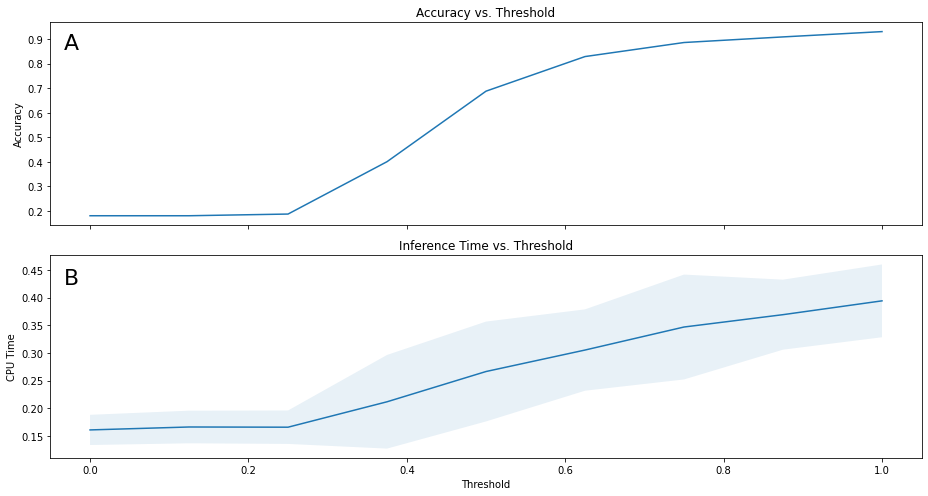

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

accs = []
sprs = []
sigs = []
gpus = []
cpus_m = []
cpus_s = []
nums_p = []
thrs = []
datas = {}
for i, (measurement, data) in enumerate(zip(measurements, values)):
    accuracy = data.get('accuracy')
    sparsity = data.get('sparsity')
    significance = data.get('significance')
    gpu_time = data.get('gpu_time')
    cpu_time_mean = data.get('cpu_time_mean')
    cpu_time_std = data.get('cpu_time_std')
    num_params = data.get('num_params')
    thresh = data.get('threshold', measurements[i])
    stats = data.get('stats')
    
    accs.append(accuracy)
    sprs.append(sparsity)
    sigs.append(significance)
    gpus.append(gpu_time)
    cpus_m.append(cpu_time_mean)
    cpus_s.append(cpu_time_std)
    nums_p.append(num_params)
    thrs.append(thresh)
    datas[thresh] = stats

# Plotting accuracy vs thresholds
axs[0].plot(thrs, accs)
axs[0].set_title("Accuracy vs. Threshold")
axs[0].set_ylabel("Accuracy")
axs[0].text(-0.033, 0.86, 'A', fontsize=22)

# Plotting CPU mean time vs thresholds with standard deviation
axs[1].plot(thrs, cpus_m)
axs[1].fill_between(thrs, [m - s for m, s in zip(cpus_m, cpus_s)],  [m + s for m, s in zip(cpus_m, cpus_s)], alpha=0.1)
axs[1].set_title("Inference Time vs. Threshold")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("CPU Time")
axs[1].text(-0.033, 0.425, 'B', fontsize=22)
plt.tight_layout()
plt.show()

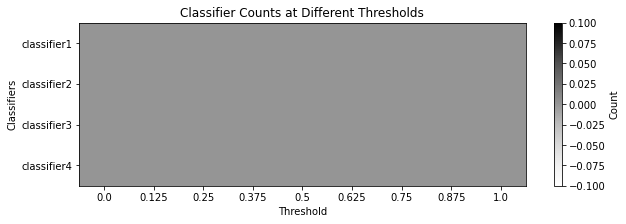

In [55]:
thresholds = list(datas.keys())
classifiers = list(datas[0].keys())
counts = [[datas[thresh][classifier] for classifier in classifiers] for thresh in thresholds]
counts_array = np.array(counts)

plt.figure(figsize=(10, 3))
plt.imshow(counts_array.T, aspect='auto', interpolation='none', cmap='Greys')
plt.colorbar(label='Count')
plt.yticks(range(len(classifiers)), classifiers)
plt.xticks(range(len(thresholds)), thresholds)
plt.ylabel('Classifiers')
plt.xlabel('Threshold')
plt.title('Classifier Counts at Different Thresholds')
plt.show()